#### 코드 원작자

[https://github.com/MousaviSajad/ECG-Heartbeat-Classification-seq2seq-model](https://github.com/MousaviSajad/ECG-Heartbeat-Classification-seq2seq-model)

In [1]:
# 데이터 다운로드
!pip install gdown

!gdown --folder https://drive.google.com/drive/folders/19bDrAqlSGQuNLRmA-7pQRU9R81gSuY70 -O ./data

Processing file 1QRN1pyPsl2bDvtYrVU4BuDfnfa0Qnfr- s2s_mitbih_aami_DS1DS2.mat
Processing file 1Lc3PkSGKIu6tju_pYV0F9eBFIEIkwAr7 s2s_mitbih_aami.mat


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1QRN1pyPsl2bDvtYrVU4BuDfnfa0Qnfr-
From (redirected): https://drive.google.com/uc?id=1QRN1pyPsl2bDvtYrVU4BuDfnfa0Qnfr-&confirm=t&uuid=d8955ced-7d97-4615-b288-2cdb5190731a
To: c:\Users\inhag\DoctorCode-Workbook\Chapter6\data\s2s_mitbih_aami_DS1DS2.mat

  0%|          | 0.00/218M [00:00<?, ?B/s]
  0%|          | 524k/218M [00:00<01:14, 2.90MB/s]
  2%|▏         | 3.67M/218M [00:00<00:13, 15.4MB/s]
  3%|▎         | 5.77M/218M [00:00<00:12, 16.5MB/s]
  4%|▍         | 9.44M/218M [00:00<00:09, 22.3MB/s]
  6%|▌         | 12.1M/218M [00:00<00:09, 22.0MB/s]
  7%|▋         | 14.7M/218M [00:00<00:11, 18.4MB/s]
  8%|▊         | 17.3M/218M [00:01<00:12, 16.5MB/s]
 10%|▉         | 21.0M/218M [00:01<00:09, 20.9MB/s]
 11%|█         | 23.6M/218M [00:01<00:10, 18.0MB/s]
 13%|█▎        | 27.3M/218M [00:01<00:08, 21

In [2]:
# 필요한 패키지 설치

!pip install numpy matplotlib scipy tensorflow scikit-learn imbalanced-learn

In [ ]:
# 라이브러리 가져오기
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import random
import time
import os
from datetime import datetime

# 재현성을 위한 난수 시드 설정
random.seed(654)
tf.random.set_seed(654)

# 학습 관련 설정값
epochs = 100
max_time = 10
batch_size = 20
num_units = 128
bidirectional = False
n_oversampling = 10000
data_dir = 'data/s2s_mitbih_aami'
checkpoint_dir = 'checkpoints-seq2seq'
classes = ['F', 'N', 'S', 'V']

# 모델 저장 디렉토리가 없으면 새로 만듭니다
if not os.path.exists(checkpoint_dir):
   os.mkdir(checkpoint_dir)

In [4]:
# 데이터셋 로드
print("데이터를 불러오는 중...")
samples = spio.loadmat(data_dir + ".mat")
samples = samples['s2s_mitbih']
values = samples[0]['seg_values']
labels = samples[0]['seg_labels']
num_annots = sum([item.shape[0] for item in values])

n_seqs = num_annots / max_time

# 데이터 처리
data = []
l_data = 0
for i, item in enumerate(values):
   for itm in item:
       if l_data == n_seqs * max_time:
           break
       data.append(itm[0])
       l_data = l_data + 1

t_lables = []
l_lables = 0
for i, item in enumerate(labels):
   if len(t_lables) == n_seqs * max_time:
       break
   item = item[0]
   for lebel in item:
       if l_lables == n_seqs * max_time:
           break
       t_lables.append(str(lebel))
       l_lables = l_lables + 1

del values
data = np.asarray(data)
shape_v = data.shape
data = np.reshape(data, [shape_v[0], -1])
t_lables = np.array(t_lables)

# 클래스별 데이터 필터링 및 샘플 수 제한
_data = np.asarray([], dtype=np.float64).reshape(0, shape_v[1])
_labels = np.asarray([], dtype=np.dtype('U1')).reshape(0,)  # 바이트 대신 유니코드 사용

for cl in classes:
   _label = np.where(t_lables == cl)
   permute = np.random.permutation(len(_label[0]))
   _label = _label[0][permute[:100000]]  # 클래스당 최대 10만 샘플
   _data = np.concatenate((_data, data[_label]))
   _labels = np.concatenate((_labels, t_lables[_label]))

# 데이터 길이가 max_time으로 나누어 떨어지게 조정
data = _data[:(len(_data) // max_time) * max_time, :]
_labels = _labels[:(len(_data) // max_time) * max_time]

# 데이터를 max_time 길이의 시퀀스로 분할
X = [data[i:i + max_time] for i in range(0, len(data), max_time)]
Y = [_labels[i:i + max_time] for i in range(0, len(_labels), max_time)]

# 데이터 셔플
permute = np.random.permutation(len(Y))
X = np.asarray(X)
Y = np.asarray(Y)
X = X[permute]
Y = Y[permute]

print(f"시퀀스 개수: {len(X)}")

# 클래스 매핑 생성
classes = np.unique(Y)
char2numY = dict(zip(classes, range(len(classes))))
n_classes = len(classes)

print(f"클래스: {classes}")
for cl in classes:
   ind = np.where(classes == cl)[0][0]
   print(f"{cl}: {len(np.where(Y.flatten()==cl)[0])}")

# 시퀀스 시작을 위한 GO 토큰 추가
char2numY['<GO>'] = len(char2numY)
num2charY = dict(zip(char2numY.values(), char2numY.keys()))

# GO 토큰으로 타겟 시퀀스 준비
Y = [[char2numY['<GO>']] + [char2numY[y_] for y_ in date] for date in Y]
Y = np.array(Y)

input_depth = X.shape[2]
n_channels = 10
x_seq_length = len(X[0])
y_seq_length = len(Y[0]) - 1

# 훈련 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# SMOTE를 사용한 오버샘플링 적용
print("SMOTE 오버샘플링 적용 중...")
X_train_flat = np.reshape(X_train, [X_train.shape[0]*X_train.shape[1], -1])
y_train_flat = y_train[:, 1:].flatten()

# 클래스별 샘플 수 계산
nums = []
for cl in classes:
   ind = np.where(classes == cl)[0][0]
   nums.append(len(np.where(y_train_flat==ind)[0]))

# 오버샘플링 비율 설정
ratio = {0: n_oversampling, 1: nums[1], 2: n_oversampling, 3: n_oversampling}
sm = SMOTE(random_state=12, sampling_strategy=ratio)
X_train_flat, y_train_flat = sm.fit_resample(X_train_flat, y_train_flat)

# 데이터를 시퀀스로 다시 변형
X_train_flat = X_train_flat[:(X_train_flat.shape[0]//max_time)*max_time, :]
y_train_flat = y_train_flat[:(X_train_flat.shape[0]//max_time)*max_time]

X_train = np.reshape(X_train_flat, [-1, X_test.shape[1], X_test.shape[2]])
y_train_reshaped = np.reshape(y_train_flat, [-1, y_test.shape[1]-1])
y_train = np.array([[char2numY['<GO>']] + list(date) for date in y_train_reshaped])

# 오버샘플링 후 클래스 분포 출력
print("오버샘플링 후 훈련 세트의 클래스 분포:")
for cl in classes:
   ind = np.where(classes == cl)[0][0]
   print(f"{cl}: {len(np.where(y_train.flatten()==ind)[0])}")

# 배치 생성기 함수 정의
def get_batch(x, y, batch_size):
   indices = np.random.randint(0, len(x), batch_size)
   return x[indices], y[indices]

데이터를 불러오는 중...
시퀀스 개수: 10130
클래스: ['F' 'N' 'S' 'V']
F: 802
N: 90502
S: 2777
V: 7219
SMOTE 오버샘플링 적용 중...


c:\Users\inhag\.virtualenvs\Chapter6-JcyiWNwd\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\inhag\.virtualenvs\Chapter6-JcyiWNwd\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\inhag\.pyenv\pyenv-win\versions\3.12.8\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\inhag\.pyenv\pyenv-win\versions\3.12.8\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\inhag\.pyenv\pyenv-win\versions\3.12.8\Li

오버샘플링 후 훈련 세트의 클래스 분포:
F: 10000
N: 72432
S: 10000
V: 9998


In [5]:
# Keras로 모델 구축
def create_model():
   # 입력 레이어 정의
   input_layer = tf.keras.layers.Input(shape=(max_time, input_depth), name='inputs')
   decoder_inputs = tf.keras.layers.Input(shape=(y_seq_length,), name='dec_inputs')
   
   # CNN을 위한 데이터 형태 변환
   x = tf.keras.layers.Reshape((-1, n_channels, input_depth // n_channels))(input_layer)
   x = tf.keras.layers.Permute((2, 1, 3))(x)  # 차원 순서 변경
   x = tf.keras.layers.Reshape((-1, input_depth // n_channels))(x)
   
   # CNN 레이어 (특징 추출)
   x = tf.keras.layers.Conv1D(32, 2, padding='same', activation='relu')(x)
   x = tf.keras.layers.MaxPooling1D(2, 2, padding='same')(x)
   
   x = tf.keras.layers.Conv1D(64, 2, padding='same', activation='relu')(x)
   x = tf.keras.layers.MaxPooling1D(2, 2, padding='same')(x)
   
   x = tf.keras.layers.Conv1D(128, 2, padding='same', activation='relu')(x)
   
   # RNN을 위한 시퀀스 형태로 변환
   x = tf.keras.layers.Reshape((max_time, -1))(x)
   
   # 인코더 (시퀀스를 고정 크기 벡터로 변환)
   if bidirectional:
       encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units))(x)
   else:
       encoder = tf.keras.layers.LSTM(num_units)(x)
   
   # 디코더 입력 임베딩
   decoder_embed = tf.keras.layers.Embedding(len(char2numY), 10)(decoder_inputs)
   
   # 인코더 상태를 디코더의 각 타임스텝에 반복
   encoder_repeat = tf.keras.layers.RepeatVector(y_seq_length)(encoder)
   
   # 디코더 입력과 인코더 상태 연결
   decoder_concat = tf.keras.layers.Concatenate()([decoder_embed, encoder_repeat])
   
   # 디코더 (고정 크기 벡터에서 시퀀스 생성)
   if bidirectional:
       decoder_outputs = tf.keras.layers.Bidirectional(
           tf.keras.layers.LSTM(num_units, return_sequences=True)
       )(decoder_concat)
   else:
       decoder_outputs = tf.keras.layers.LSTM(num_units, return_sequences=True)(decoder_concat)
   
   # 출력 레이어 (각 타임스텝의 클래스 확률)
   outputs = tf.keras.layers.Dense(len(char2numY), activation='softmax')(decoder_outputs)
   
   # 모델 생성
   model = tf.keras.Model([input_layer, decoder_inputs], outputs)
   
   # 모델 컴파일 (학습 설정)
   model.compile(
       optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
       loss='sparse_categorical_crossentropy',
       metrics=['accuracy']
   )
   
   return model

# 모델 생성
model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 10, 280)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 10, 10,    │          0 │ inputs[0][0]      │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 10, 10,    │          0 │ reshape[0][0]     │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 100, 28)   │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 32)   │      1,824 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 64)    │      4,160 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 25, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 25, 128)   │     16,512 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 10, 320)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    229,888 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 10)    │         50 │ dec_inputs[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 10, 128)   │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 138)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 10, 128)   │    136,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 5)     │        645 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 389,783 (1.49 MB)

 Trainable params: 389,783 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 콜백 설정
checkpoint_path = os.path.join(checkpoint_dir, "model.weights.h5")  # 파일 확장자 변경
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   filepath=checkpoint_path,
   save_weights_only=True,
   save_best_only=True,
   monitor='val_accuracy',
   verbose=1
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
   monitor='val_loss',
   patience=10,
   verbose=1
)

# 훈련 함수
def train_model():
   # 검증 데이터 준비
   val_size = len(X_test) // 4
   X_val = X_test[:val_size]
   y_val = y_test[:val_size]
   
   # 훈련 기록 저장용 딕셔너리
   history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
   
   for epoch in range(epochs):
       print(f"\n에포크 {epoch+1}/{epochs}")
       start_time = time.time()
       
       # 이 에포크의 훈련 지표
       epoch_loss = []
       epoch_acc = []
       
       # 훈련 루프
       num_batches = len(X_train) // batch_size
       for batch in range(num_batches):
           # 배치 데이터 가져오기
           X_batch, y_batch = get_batch(X_train, y_train, batch_size)
           
           # 배치 학습
           batch_loss, batch_acc = model.train_on_batch(
               [X_batch, y_batch[:, :-1]],  # 입력
               y_batch[:, 1:],              # 타겟
           )
           
           epoch_loss.append(batch_loss)
           epoch_acc.append(batch_acc)
           
           # 진행상황 출력
           if (batch + 1) % 10 == 0:
               print(f"배치 {batch+1}/{num_batches} - 손실: {batch_loss:.4f} - 정확도: {batch_acc:.4f}")
       
       # 검증
       val_loss = []
       val_acc = []
       
       for i in range(0, len(X_val), batch_size):
           X_val_batch = X_val[i:i+batch_size]
           y_val_batch = y_val[i:i+batch_size]
           
           if len(X_val_batch) < batch_size:
               continue
               
           val_batch_loss, val_batch_acc = model.test_on_batch(
               [X_val_batch, y_val_batch[:, :-1]],
               y_val_batch[:, 1:]
           )
           
           val_loss.append(val_batch_loss)
           val_acc.append(val_batch_acc)
       
       # 평균 지표 계산
       avg_loss = np.mean(epoch_loss)
       avg_acc = np.mean(epoch_acc)
       avg_val_loss = np.mean(val_loss)
       avg_val_acc = np.mean(val_acc)
       
       # 히스토리 업데이트
       history["loss"].append(avg_loss)
       history["accuracy"].append(avg_acc)
       history["val_loss"].append(avg_val_loss)
       history["val_accuracy"].append(avg_val_acc)
       
       # 에포크 결과 출력
       print(f"에포크 {epoch+1}/{epochs} - 손실: {avg_loss:.4f} - 정확도: {avg_acc:.4f} - "
             f"검증 손실: {avg_val_loss:.4f} - 검증 정확도: {avg_val_acc:.4f} - "
             f"소요 시간: {time.time() - start_time:.2f}초")
       
       # 검증 정확도가 향상되면 모델 저장
       if epoch > 0 and avg_val_acc > max(history["val_accuracy"][:-1]):
           print("모델 저장 중...")
           model.save_weights(checkpoint_path)
   
   return history

# 모델 훈련
history = train_model()


에포크 1/10
배치 10/512 - 손실: 1.1036 - 정확도: 0.6360
배치 20/512 - 손실: 0.9625 - 정확도: 0.6910
배치 30/512 - 손실: 0.8346 - 정확도: 0.7175
배치 40/512 - 손실: 0.7131 - 정확도: 0.7591
배치 50/512 - 손실: 0.6424 - 정확도: 0.7792
배치 60/512 - 손실: 0.5740 - 정확도: 0.8033
배치 70/512 - 손실: 0.5165 - 정확도: 0.8234
배치 80/512 - 손실: 0.4794 - 정확도: 0.8368
배치 90/512 - 손실: 0.4399 - 정확도: 0.8503
배치 100/512 - 손실: 0.4039 - 정확도: 0.8630
배치 110/512 - 손실: 0.3801 - 정확도: 0.8722
배치 120/512 - 손실: 0.3543 - 정확도: 0.8812
배치 130/512 - 손실: 0.3339 - 정확도: 0.8878
배치 140/512 - 손실: 0.3128 - 정확도: 0.8953
배치 150/512 - 손실: 0.2941 - 정확도: 0.9018
배치 160/512 - 손실: 0.2804 - 정확도: 0.9062
배치 170/512 - 손실: 0.2683 - 정확도: 0.9104
배치 180/512 - 손실: 0.2547 - 정확도: 0.9151
배치 190/512 - 손실: 0.2495 - 정확도: 0.9172
배치 200/512 - 손실: 0.2382 - 정확도: 0.9211
배치 210/512 - 손실: 0.2281 - 정확도: 0.9246
배치 220/512 - 손실: 0.2192 - 정확도: 0.9276
배치 230/512 - 손실: 0.2153 - 정확도: 0.9291
배치 240/512 - 손실: 0.2081 - 정확도: 0.9316
배치 250/512 - 손실: 0.2013 - 정확도: 0.9340
배치 260/512 - 손실: 0.1941 - 정확도: 0.9365
배치 270/512 

C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:86: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:86: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:86: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:86: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:86: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:86: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) 

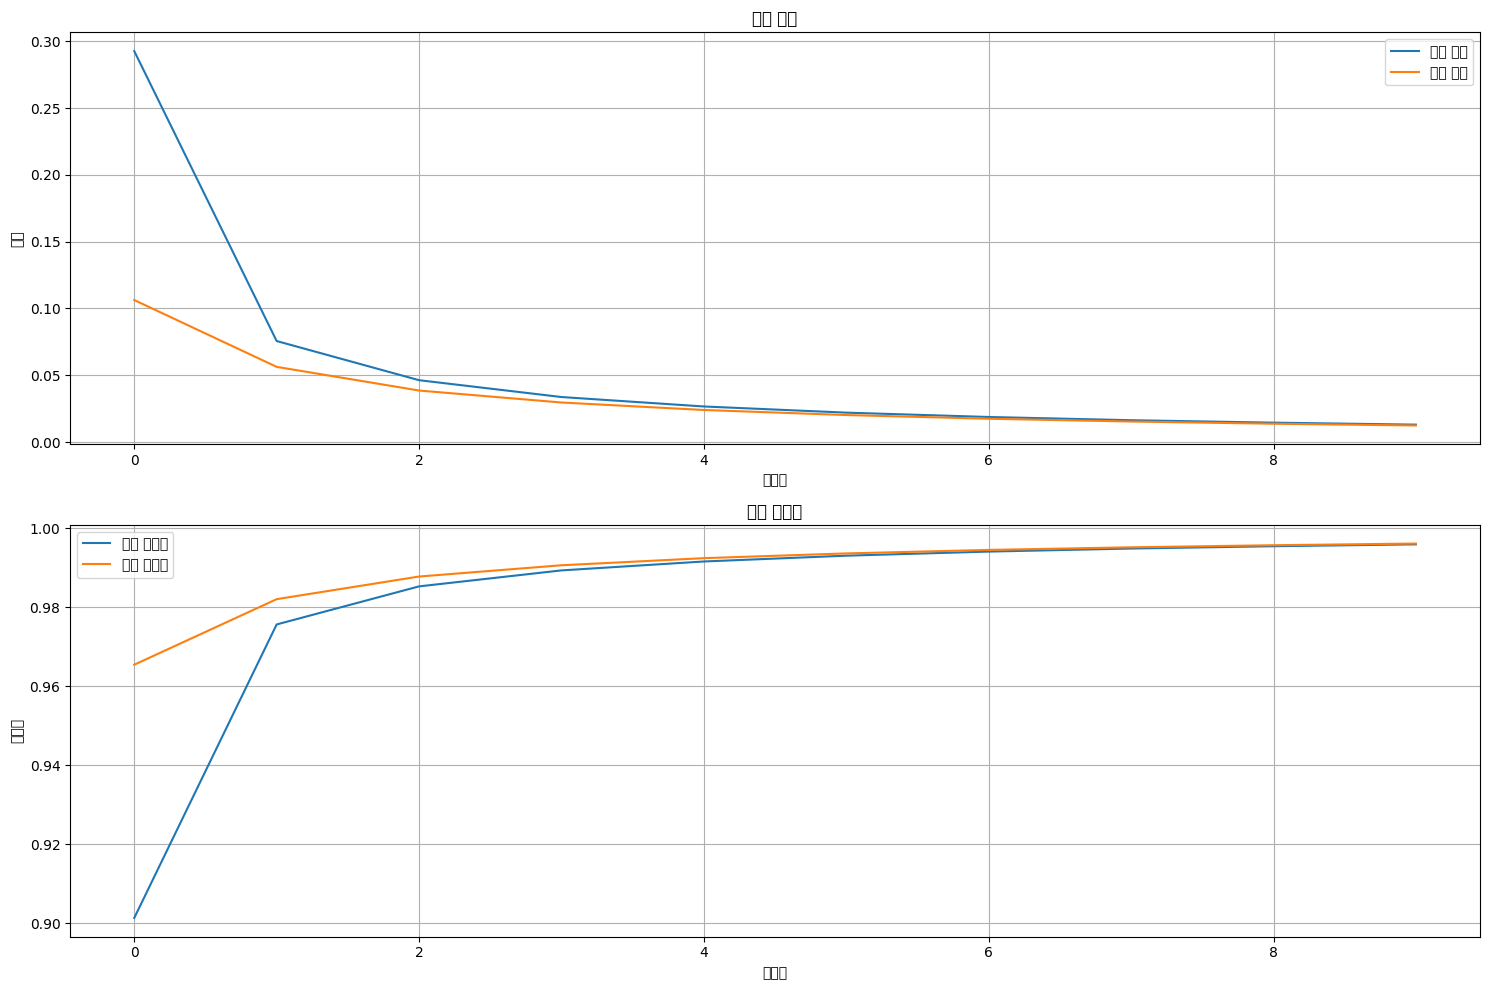


최종 모델 평가:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:112: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:112: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:112: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:112: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:115: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix.png')
C:\Users\inhag\AppData\Local\Temp\ipykernel_29592\950658244.py:115: UserWarning: Glyph 51228 (\N{HANGUL SYLL

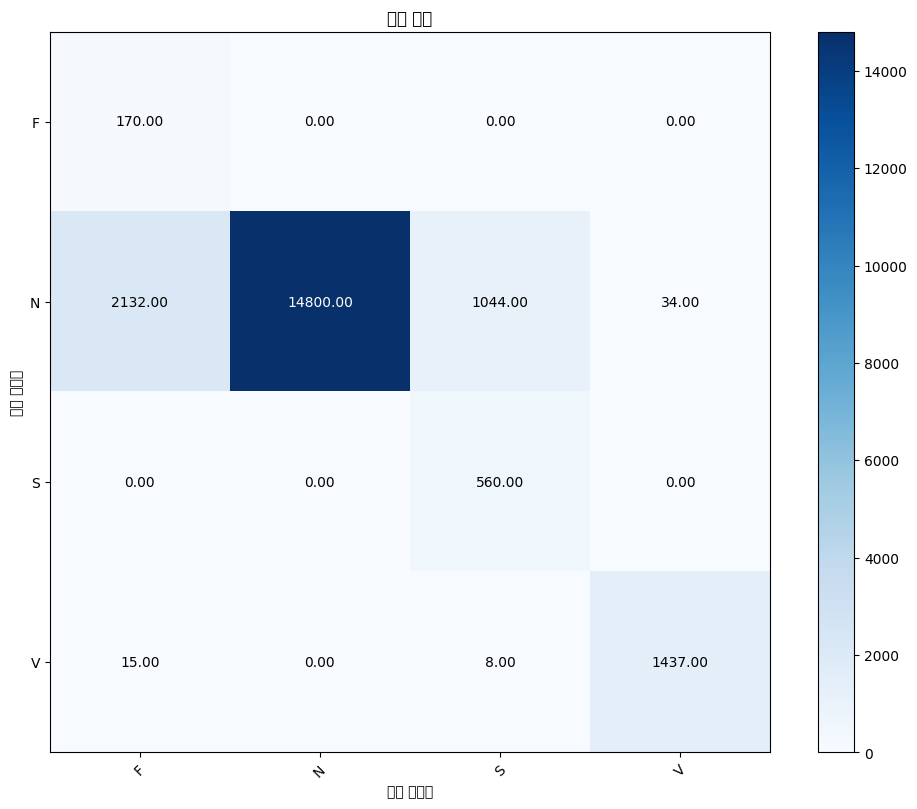

In [7]:
# 모델 평가
def evaluate_model():
   # 최상의 가중치 로드
   model.load_weights(checkpoint_path)
   
   # 혼동 행렬(Confusion Matrix) 계산을 위한 준비
   y_true = []
   y_pred = []
   
   for i in range(0, len(X_test), batch_size):
       X_batch = X_test[i:i+batch_size]
       y_batch = y_test[i:i+batch_size]
       
       if len(X_batch) < batch_size:
           continue
           
       # 예측
       dec_input = np.zeros((len(X_batch), 1), dtype=np.int32) + char2numY['<GO>']
       dec_input_expanded = np.zeros((len(X_batch), y_seq_length), dtype=np.int32)
       dec_input_expanded[:, 0] = char2numY['<GO>']
       
       predictions = model.predict([X_batch, dec_input_expanded])
       
       # 예측된 인덱스 얻기
       pred_indices = np.argmax(predictions, axis=2)
       
       # 실제값과 예측값 수집
       y_true.extend(y_batch[:, 1:].flatten())
       y_pred.extend(pred_indices.flatten())
   
   # 혼동 행렬 계산
   conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(char2numY)-1))
   
   # 성능 지표 계산
   FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  # 위양성(False Positive)
   FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)  # 위음성(False Negative)
   TP = np.diag(conf_matrix)  # 진양성(True Positive)
   TN = conf_matrix.sum() - (FP + FN + TP)  # 진음성(True Negative)
   
   # 민감도/재현율(Sensitivity/Recall)
   TPR = TP / (TP + FN + 1e-7)  # 0으로 나누는 오류 방지를 위해 작은 값 추가
   # 특이도(Specificity)
   TNR = TN / (TN + FP + 1e-7)
   # 정밀도(Precision/PPV)
   PPV = TP / (TP + FP + 1e-7)
   # 정확도(Accuracy)
   ACC = (TP + TN) / (TP + FP + FN + TN + 1e-7)
   # 매크로 평균 정확도(Macro accuracy)
   ACC_macro = np.mean(ACC)
   
   print(f'평균 정확도: {ACC_macro:.4f} (테스트 세트)')
   for index_ in range(n_classes):
       print(f"  {classes[index_]} 리듬 -> 민감도: {TPR[index_]:.4f}, "
             f"특이도: {TNR[index_]:.4f}, "
             f"정밀도: {PPV[index_]:.4f}, "
             f"정확도: {ACC[index_]:.4f}")
   
   print(f"  평균 -> 민감도: {np.mean(TPR):.4f}, "
         f"특이도: {np.mean(TNR):.4f}, "
         f"정밀도: {np.mean(PPV):.4f}, "
         f"정확도: {np.mean(ACC):.4f}")
   
   return conf_matrix

# 훈련 이력 그래프 그리기
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='훈련 손실')
plt.plot(history['val_loss'], label='검증 손실')
plt.title('모델 손실')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='훈련 정확도')
plt.plot(history['val_accuracy'], label='검증 정확도')
plt.title('모델 정확도')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# 모델 평가 및 혼동 행렬 계산
print("\n최종 모델 평가:")
conf_matrix = evaluate_model()

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('혼동 행렬')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 텍스트 주석 추가
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
   for j in range(conf_matrix.shape[1]):
       plt.text(j, i, format(conf_matrix[i, j], '.2f'),
               ha="center", va="center",
               color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('실제 레이블')
plt.xlabel('예측 레이블')
plt.savefig('confusion_matrix.png')
plt.show()